In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
import matplotlib.patches as patches
import keras
from sklearn.model_selection import train_test_split
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "/content/drive/MyDrive/Train Ai/archive/lfw-deepfunneled/lfw-deepfunneled/"

In [2]:
# Đọc và làm sạch dữ liệu

lfw_allnames = pd.read_csv("/content/drive/MyDrive/Train Ai/archive/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("/content/drive/MyDrive/Train Ai/archive/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("/content/drive/MyDrive/Train Ai/archive/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("/content/drive/MyDrive/Train Ai/archive/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("/content/drive/MyDrive/Train Ai/archive/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("/content/drive/MyDrive/Train Ai/archive/pairs.csv")
# tạo ra hai DataFrame mới ('matched_pairs' và 'mismatched_pairs')
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("/content/drive/MyDrive/Train Ai/archive/people.csv")
# xóa giá trị null
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("/content/drive/MyDrive/Train Ai/archive/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("/content/drive/MyDrive/Train Ai/archive/peopleDevTrain.csv")

In [3]:
# tạo ra một DataFrame mới 'image_paths' với thông tin đường dẫn đầy đủ đến các
# file ảnh tương ứng với mỗi dòng trong DataFrame 'lfw_allnames'.
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop(labels="images", axis=1)

# lấy một mẫu ngẫu nhiên: 80% dữ liệu cho bộ kiểm tra
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop(labels="index", axis=1)
lfw_test = lfw_test.reset_index().drop(labels="index", axis=1)

print("so luong nhan vat xuat hien trong ca train và test")
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print("so luong nhan vat chi xuat hien trong test")
print(len(set(lfw_test.name) - set(lfw_train.name)))


so luong nhan vat xuat hien trong ca train và test
850
so luong nhan vat chi xuat hien trong test
867


<Axes: >

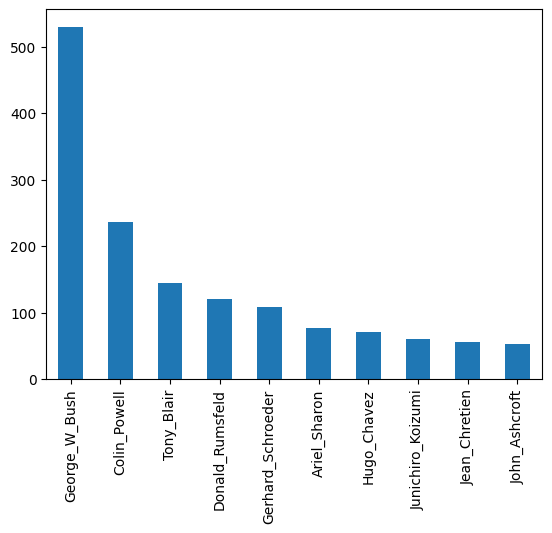

In [6]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [5]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " cá nhân, chiếm " +
      str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) +
      "% trên tổng số cá nhân được xem xét, chỉ có một hình ảnh duy nhất trong bộ dữ liệu này.")

4069 cá nhân, chiếm 31% trên tổng số cá nhân được xem xét, chỉ có một hình ảnh duy nhất trong bộ dữ liệu này.


Xây dựng mô hình nhận diện cho cá nhân có số ảnh nhiều nhất



In [4]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [5]:
# chia dữ liệu test train val
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)

bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [6]:
# khởi tạo mạng tuần tự
from keras.models import Sequential
# bao gồm các lớp tích chập
from keras.layers import Conv2D
# gộp các lớp
from keras.layers import MaxPooling2D
# làm phẳng các lớp thành một vector
from keras.layers import Flatten
from keras.layers import Dense

In [7]:
# sử dụng trình phân loại tuần tự - triển khai CNN tiêu chuẩn với đầu vào đơn giản
Bush_classifier = Sequential()

#Lớp đầu tiên thêm vào là lớp tích chập 2D chuyển qua hình ảnh bằng cửa sổ 3x3 và đầu vào 250*250 pixel
#Hàm kích hoạt là 'relu'
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

# thêm lớp tổng hợp để giảm kích thước
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Bước tiếp theo là làm phẳng dữ liệu, giảm các bản đồ đặc trưng thành mảng 1D
Bush_classifier.add(Flatten())

#Sau đó thêm một lớp được kết nối đầy đủ - Perceptron
Bush_classifier.add(Dense(units = 128, activation = 'relu'))

#vì chỉ đào tạo để phân loại 'Bush' với 'không phải Bush' nên chỉ cần thêm một đơn vị phân loại units = 1
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [8]:
# hàm di chuyển ảnh tới train/test/val

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # tạo thư mục đích
        if not os.path.exists(os.path.join('/content/drive/MyDrive/Train Ai/archive/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/content/drive/MyDrive/Train Ai/archive/working/',dir_name))

        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/content/drive/MyDrive/Train Ai/archive/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/content/drive/MyDrive/Train Ai/archive/working',dir_name,data_type))
        path_from = os.path.join('/content/drive/MyDrive/Train Ai/archive/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('/content/drive/MyDrive/Train Ai/archive/working',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1

    print('Moved {} images to {} folder.'.format(co,dir_name))

In [9]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [10]:
import keras
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Bush_training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working/Bush_train/',
                                                     target_size=(250, 250),
                                                     batch_size=32,
                                                     class_mode='binary')


Bush_val_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Bush_test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')



Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [ ]:
Bush_history  = Bush_classifier.fit(Bush_training_set,
                                            steps_per_epoch=21,
                                            epochs=35,
                                            validation_data=Bush_val_set,
                                            validation_steps=len(Bush_val_set))


Epoch 1/35
21/21 [==============================] - 360s 17s/step - loss: 9.2965 - accuracy: 0.5263 - val_loss: 0.9403 - val_accuracy: 0.7059
Epoch 2/35
21/21 [==============================] - 13s 620ms/step - loss: 1.0923 - accuracy: 0.5511 - val_loss: 0.8030 - val_accuracy: 0.5941
Epoch 3/35
21/21 [==============================] - 11s 545ms/step - loss: 0.6786 - accuracy: 0.6192 - val_loss: 0.6669 - val_accuracy: 0.6353
Epoch 4/35
21/21 [==============================] - 11s 521ms/step - loss: 0.6017 - accuracy: 0.6796 - val_loss: 0.5897 - val_accuracy: 0.7000
Epoch 5/35
21/21 [==============================] - 10s 474ms/step - loss: 0.5285 - accuracy: 0.7415 - val_loss: 0.5021 - val_accuracy: 0.7765
Epoch 6/35
21/21 [==============================] - 12s 579ms/step - loss: 0.4945 - accuracy: 0.7709 - val_loss: 0.4953 - val_accuracy: 0.7706
Epoch 7/35
21/21 [==============================] - 11s 549ms/step - loss: 0.4087 - accuracy: 0.8189 - val_loss: 0.4041 - val_accuracy: 0.8353


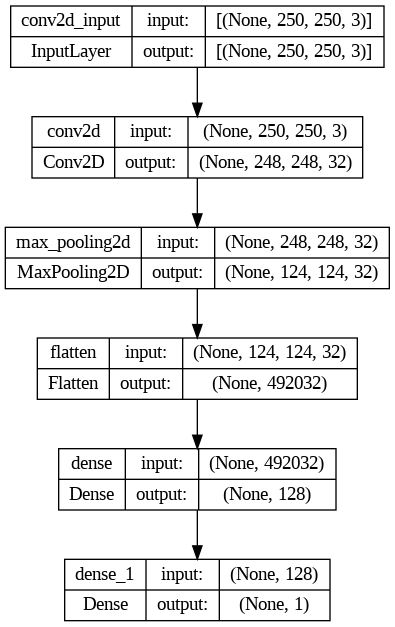

In [ ]:
from keras.utils import plot_model

# Vẽ mô hình
plot_model(Bush_classifier, to_file='bush_classifier.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Đường dẫn tới nơi bạn muốn lưu mô hình
model_save_path = "/content/drive/MyDrive/Train Ai/model/George_W_Bush1.h5"

# Lưu mô hình
Bush_classifier.save(model_save_path)

In [ ]:
from keras.models import load_model

# Đường dẫn tới tệp mô hình đã lưu
model_filename = "/content/drive/MyDrive/Train Ai/model/George_W_Bush1.h5"

# Tải mô hình
Bush_classifier  = load_model(model_filename)


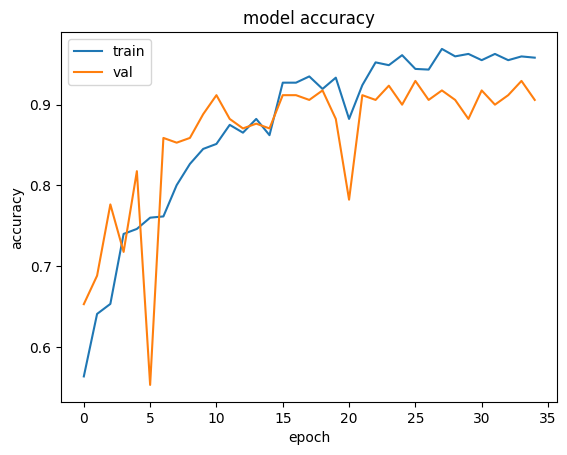

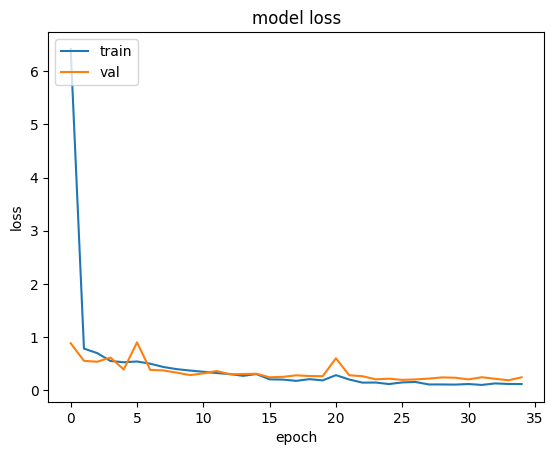

In [ ]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

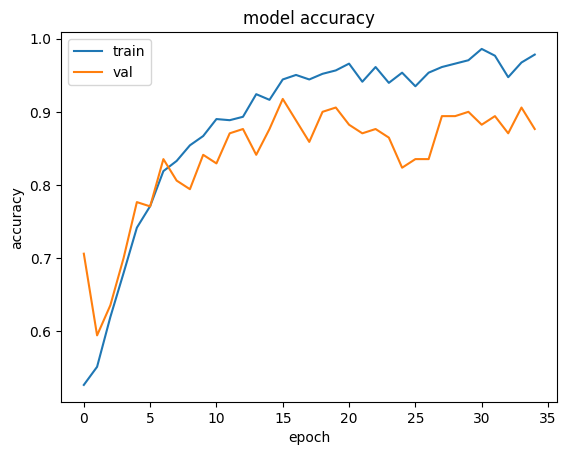

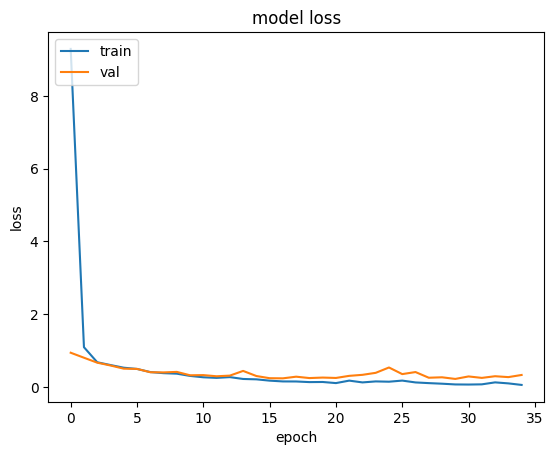

In [ ]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# tạo một hàm để dự đoán lớp hình ảnh trong một thư mục, được cung cấp một bộ phân loại được đào tạo
def predictions(dir_name, classifier, binary):
    #dir_name nên bao gồm tên của cá nhân được dự đoán - có thể chỉnh sửa tên này để lặp qua các thư mục trong tương lai
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size=(250, 250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)
        if binary is True:
            result = float(str(classifier.predict(test_image))[2])
        else:
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return predictions


In [ ]:
#lấy tên các lớp
Bush_test_names = []
# lấy tất cả tên tập tin
for i in range(len(Bush_test_set.filenames)):
    Bush_test_names.append(Bush_test_set.filenames[i])
# trích xuất tên bỏ phần mở rộng, theo thứ tự
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))
print(Bush_test_names)
print(Bush_test_name_order)

['George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bus

In [ ]:
# Tính toán dự đoán
Bush_predictions_0 = predictions("/content/drive/MyDrive/Train Ai/archive/working/Bush_test/"+
                                 Bush_test_name_order[0] + "/",Bush_classifier,binary = True)
Bush_predictions_1 = predictions("/content/drive/MyDrive/Train Ai/archive/working/Bush_test/"+
                                 Bush_test_name_order[1] + "/",Bush_classifier, binary = True)

# So sánh dự đoán với các lớp thực tế
Bush_predictions_frame = pd.DataFrame(list(zip(Bush_predictions_0 + Bush_predictions_1,
                                                [0] * len(Bush_predictions_0) + [1] * len(Bush_predictions_1))),
                                       columns = ['Predictions','Actual'])

1/1 [==============================] - 0s 18ms/step


In [11]:
# hàm tính accuracy, precision, recall
def prec_acc_2_class(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in set(predictions_frame.Actual):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]

        print('Class', i)
        print('tp:', tp)
        print('fp:', fp)
        print('fn:', fn)

        if i == 0:
            precision.append(tp / (tp + fp))
            recall.append(tp / (tp + fn))

        elif i == 1:
            precision.append(tp / (tp + fp))
            recall.append(tp / (tp + fn))

        accuracy.append((tp + tn) / total_preds)

    return accuracy, precision, recall


In [ ]:
Bush_accuracy = prec_acc_2_class(Bush_predictions_frame)
print('Precision:' + str(Bush_accuracy[1]))
print('Recall:' + str(Bush_accuracy[2]))
print(Bush_test_name_order)

Class 0
tp: 86
fp: 18
fn: 10
Class 1
tp: 96
fp: 9
fn: 20
Precision:[0.8269230769230769, 0.9142857142857143]
Recall:[0.8958333333333334, 0.8275862068965517]
['George_W_Bush', 'not_George']


In [ ]:
Bush_accuracy = prec_acc_2_class(Bush_predictions_frame)
print('Precision:' + str(Bush_accuracy[1]))
print('Recall:' + str(Bush_accuracy[2]))
print(Bush_test_name_order)

Class 0
tp: 91
fp: 17
fn: 5
Class 1
tp: 97
fp: 5
fn: 19
Precision:[0.8425925925925926, 0.9509803921568627]
Recall:[0.9479166666666666, 0.8362068965517241]
['George_W_Bush', 'not_George']


In [ ]:

from PIL import Image

input_dir = '/content/drive/MyDrive/Train Ai/archive/working/'
output_dir = '/content/drive/MyDrive/Train Ai/archive/working1/'

folders = ['Bush_train', 'Bush_test', 'Bush_val']
subfolders = ['not_George', 'George_W_Bush']

# Lặp qua từng thư mục
for folder in folders:
    # Tạo đường dẫn đầu vào và đầu ra
    input_folder_path = os.path.join(input_dir, folder)
    output_folder_path = os.path.join(output_dir, folder)

    # Tạo các thư mục đầu ra nếu chưa tồn tại
    os.makedirs(output_folder_path, exist_ok=True)

    # Lặp qua từng thư mục con
    for subfolder in subfolders:
        # Tạo đường dẫn đầu vào và đầu ra cho thư mục con
        input_subfolder_path = os.path.join(input_folder_path, subfolder)
        output_subfolder_path = os.path.join(output_folder_path, subfolder)

        # Tạo thư mục đầu ra cho thư mục con nếu chưa tồn tại
        os.makedirs(output_subfolder_path, exist_ok=True)

        # Lặp qua từng tệp tin ảnh trong thư mục con
        for filename in os.listdir(input_subfolder_path):
            # Tạo đường dẫn đầu vào và đầu ra cho ảnh
            input_image_path = os.path.join(input_subfolder_path, filename)
            output_image_path = os.path.join(output_subfolder_path, filename)

            # Đọc ảnh màu và chuyển đổi thành ảnh xám
            image = cv2.imread(input_image_path)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Phát hiện khuôn mặt trong ảnh
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # Cắt phần có khuôn mặt và lưu vào đường dẫn đầu ra
            for (x, y, w, h) in faces:
                face = gray_image[y:y+h, x:x+w]

                # Đưa ảnh về kích thước 120x120
                resized_face = cv2.resize(face, (250, 250))

                # Lưu ảnh đã đổi kích thước bằng PIL
                pil_image = Image.fromarray(resized_face)
                pil_image.save(os.path.join(output_subfolder_path, filename))


In [ ]:
import os
import pandas as pd
from PIL import Image

folder_path = "/content/drive/MyDrive/Train Ai/archive/working1/Bush_train/George_W_Bush"

# Lấy danh sách tất cả các tệp tin trong thư mục
file_list = os.listdir(folder_path)

widths = []
heights = []

# Lặp qua từng tệp tin
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)

    # Kiểm tra nếu là một tệp tin ảnh
    if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Mở ảnh bằng PIL
        image = Image.open(file_path)

        # Lấy độ phân giải của ảnh
        resolution = image.size
        width, height = resolution

        widths.append(width)
        heights.append(height)

        image.close()

# Tạo DataFrame từ widths và heights
df = pd.DataFrame({'Width': widths, 'Height': heights})

# Thống kê độ phân giải của các ảnh
statistics = df.describe()
print(statistics)


       Width  Height
count  336.0   336.0
mean   250.0   250.0
std      0.0     0.0
min    250.0   250.0
25%    250.0   250.0
50%    250.0   250.0
75%    250.0   250.0
max    250.0   250.0


In [ ]:
Bush_classifier_w1 = Sequential()
Bush_classifier_w1.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
Bush_classifier_w1.add(MaxPooling2D(pool_size = (2, 2)))
Bush_classifier_w1.add(Flatten())
Bush_classifier_w1.add(Dense(units = 128, activation = 'relu'))
Bush_classifier_w1.add(Dense(units = 1, activation = 'sigmoid'))
Bush_classifier_w1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
train_datagen_w1 = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen_w1 = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Bush_training_set_w1 = train_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working1/Bush_train/',
                                                     target_size=(250, 250),
                                                     batch_size=32,
                                                     class_mode='binary')


Bush_val_set_w1 = test_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working1/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Bush_test_set_w1 = test_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working1/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')



Found 662 images belonging to 2 classes.
Found 163 images belonging to 2 classes.
Found 206 images belonging to 2 classes.


In [ ]:

Bush_history_w1  = Bush_classifier_w1.fit(Bush_training_set_w1,
                                            steps_per_epoch=16,
                                            epochs=30,
                                            validation_data=Bush_val_set_w1,
                                            validation_steps=len(Bush_val_set_w1))

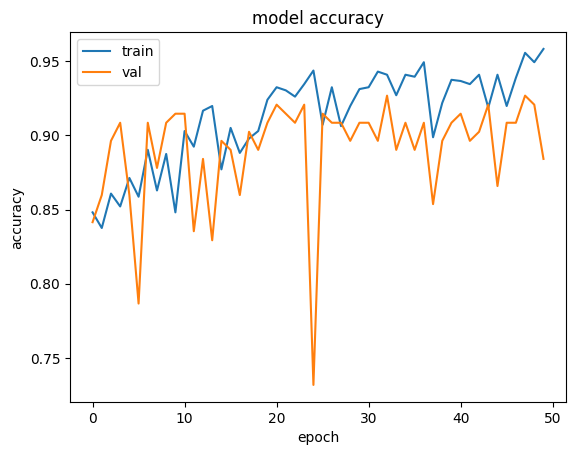

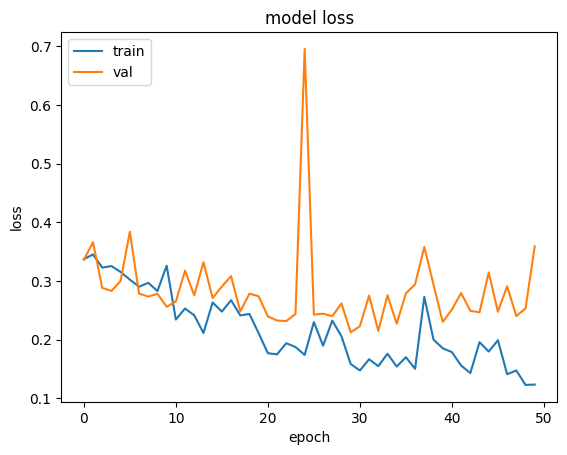

In [ ]:
plt.plot(Bush_history_w1.history['accuracy'])
plt.plot(Bush_history_w1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history_w1.history['loss'])
plt.plot(Bush_history_w1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def predictions_w1(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else:
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

In [ ]:
# các lớp được chuyển qua thuật toán theo thứ tự ngẫu nhiên - chúng tôi muốn truy xuất thứ tự của các lớp
Bush_test_names_w1 = []
# lấy tất cả tên tập tin
for i in range(len(Bush_test_set_w1.filenames)):
    Bush_test_names_w1.append(Bush_test_set_w1.filenames[i])
# trích xuất tên bỏ phần mở rộng, theo thứ tự
for i in range(len(Bush_test_names_w1)):
    Bush_test_names_w1[i] = Bush_test_names_w1[i].split("/")[0]
Bush_test_name_order_w1 = list(OrderedDict.fromkeys(Bush_test_names_w1))
print(Bush_test_names_w1)
print(Bush_test_name_order_w1)



['George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'George_W_Bus

In [ ]:
print(Bush_test_name_order_w1[1])

not_George


In [ ]:
# Tính toán dự đoán
Bush_predictions_w1_0 = predictions_w1("/content/drive/MyDrive/Train Ai/archive/working1/Bush_test/"+ Bush_test_name_order_w1[0] + "/",Bush_classifier,binary = True)
Bush_predictions_w1_1 = predictions_w1("/content/drive/MyDrive/Train Ai/archive/working1/Bush_test/"+ Bush_test_name_order_w1[1] + "/",Bush_classifier, binary = True)



# So sánh dự đoán với các lớp thực tế
Bush_predictions_frame_w1 = pd.DataFrame(list(zip(Bush_predictions_w1_0 + Bush_predictions_w1_1,
                                                [0] * len(Bush_predictions_w1_0) + [1] * len(Bush_predictions_w1_1))),
                                       columns = ['Predictions','Actual'])

In [ ]:
Bush_accuracy = prec_acc_2_class(Bush_predictions_frame_w1)
print('Precision:' + str(Bush_accuracy[1]))
print('Recall:' + str(Bush_accuracy[2]))
print(Bush_test_name_order)

Class 0
tp: 3
fp: 16
fn: 89
Class 1
tp: 99
fp: 88
fn: 16
Precision:[0.15789473684210525, 0.5294117647058824]
Recall:[0.03260869565217391, 0.8608695652173913]
['George_W_Bush', 'not_George']


In [ ]:
train_datagen1 = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen1 = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Bush_training_set1 = train_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working/Bush_train/',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='binary')


Bush_val_set1 = test_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working/Bush_val/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Bush_test_set1 = test_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working/Bush_test/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [ ]:
if "Bush_train" in os.listdir("./"):
    shutil.rmtree("./Bush_train")
if "Bush_val" in os.listdir("./"):
    shutil.rmtree("./Bush_val")
if "Bush_test" in os.listdir("./"):
    shutil.rmtree("./Bush_test")

Phân loại khuôn mặt: Nhiều lớp sử dụng CNN


In [12]:
# 10 cá nhân nhiều ảnh nhất

image_paths['name'].value_counts()[:10]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: name, dtype: int64

In [ ]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(70),
                        image_paths[image_paths.name=="Colin_Powell"].sample(70),
                        image_paths[image_paths.name=="Tony_Blair"].sample(70),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(70),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(70),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(70),
                        image_paths[image_paths.name=="Hugo_Chavez"].sample(70)
                        ])

In [ ]:
# chia dữ liệu train test val
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)

multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# xây mô hình
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units = 128, activation = 'relu'))

multi_classifier.add(Dense(units = 7, activation = 'softmax'))
# thay đổi hàm mất thành categorical_crossentropy
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])



In [ ]:
# move images to separate directories
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

Moved 313 images to train_multi/ folder.
Moved 79 images to val_multi/ folder.
Moved 98 images to test_multi/ folder.


In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working/train_multi',
                                                 target_size = (250, 250),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working/val_multi',
                                            target_size = (250, 250),
                                            batch_size = 16,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Train Ai/archive/working/test_multi',
                                            target_size = (250, 250),
                                            batch_size = 16,
                                            class_mode = 'categorical')


Found 313 images belonging to 7 classes.
Found 79 images belonging to 7 classes.
Found 98 images belonging to 7 classes.


In [ ]:
multi_history = multi_classifier.fit(multi_training_set,
                                               steps_per_epoch = 20,
                                               epochs = 55,
                                               validation_data = multi_val_set,
                                               validation_steps = len(multi_val_set))

Epoch 1/55
20/20 [==============================] - 6s 295ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 1.0945 - val_accuracy: 0.7975
Epoch 2/55
20/20 [==============================] - 5s 261ms/step - loss: 0.0280 - accuracy: 0.9904 - val_loss: 0.8255 - val_accuracy: 0.7975
Epoch 3/55
20/20 [==============================] - 6s 295ms/step - loss: 0.0619 - accuracy: 0.9776 - val_loss: 0.8010 - val_accuracy: 0.8608
Epoch 4/55
20/20 [==============================] - 5s 272ms/step - loss: 0.0562 - accuracy: 0.9840 - val_loss: 0.7946 - val_accuracy: 0.7722
Epoch 5/55
20/20 [==============================] - 5s 251ms/step - loss: 0.0500 - accuracy: 0.9808 - val_loss: 0.9501 - val_accuracy: 0.8354
Epoch 6/55
20/20 [==============================] - 6s 319ms/step - loss: 0.0787 - accuracy: 0.9776 - val_loss: 0.9513 - val_accuracy: 0.8228
Epoch 7/55
20/20 [==============================] - 5s 245ms/step - loss: 0.1270 - accuracy: 0.9521 - val_loss: 0.9778 - val_accuracy: 0.7975
Epoch 

In [ ]:
# Đường dẫn tới nơi bạn muốn lưu mô hình
model_save_path = "/content/drive/MyDrive/Train Ai/model/2.h5"

# Lưu mô hình
multi_classifier.save(model_save_path)

In [ ]:
from keras.models import load_model

# Đường dẫn tới tệp mô hình đã lưu
model_filename = "/content/drive/MyDrive/Train Ai/model/2.h5"

# Tải mô hình
multi_classifier  = load_model(model_filename)


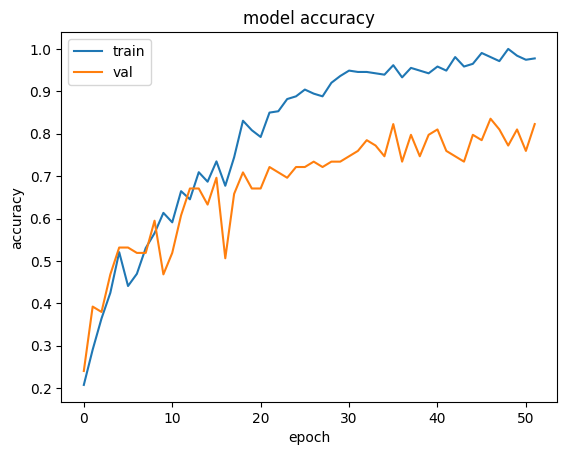

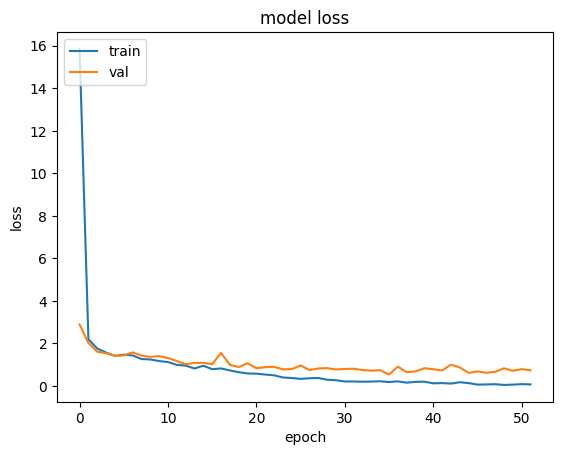

In [ ]:
plt.plot(multi_history.history['accuracy'])
plt.plot(multi_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

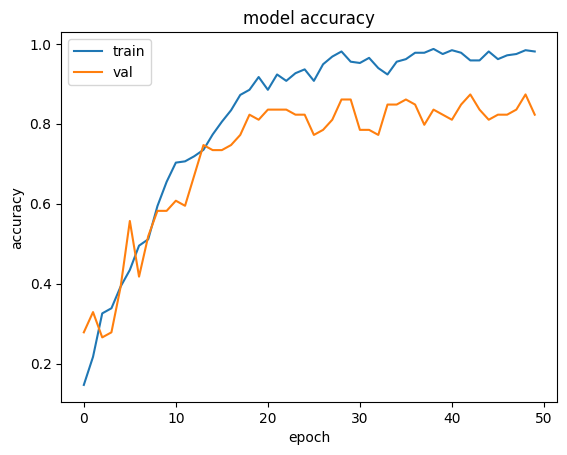

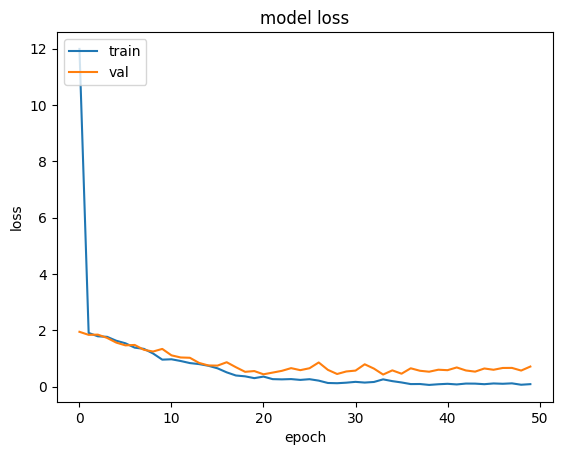

In [ ]:
plt.plot(multi_history.history['accuracy'])
plt.plot(multi_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    f1_score = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        precision.append(tp/(tp + fp))
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
        f1_score.append(2*tp*tp/(2*tp*tp+tp*fn+tp*fp))
    return(accuracy,precision,recall,f1_score)

In [ ]:
# truy xuất thứ tự và tên của các lớp
multi_test_names = []
# lấy tất file name
for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])
#trích xuất tên , theo thứ tự
for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

print(multi_test_name_order)

['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


In [ ]:
multi_predictions_0 = predictions("/content/drive/MyDrive/Train Ai/archive/working/test_multi/" + multi_test_name_order[0] + "/",multi_classifier,binary=False)
multi_predictions_1 = predictions("/content/drive/MyDrive/Train Ai/archive/working/test_multi/" + multi_test_name_order[1] + "/",multi_classifier,binary=False)
multi_predictions_2 = predictions("/content/drive/MyDrive/Train Ai/archive/working/test_multi/" + multi_test_name_order[2] + "/",multi_classifier,binary=False)
multi_predictions_3 = predictions("/content/drive/MyDrive/Train Ai/archive/working/test_multi/" + multi_test_name_order[3] + "/",multi_classifier,binary=False)
multi_predictions_4 = predictions("/content/drive/MyDrive/Train Ai/archive/working/test_multi/" + multi_test_name_order[4] + "/",multi_classifier,binary=False)
multi_predictions_5 = predictions("/content/drive/MyDrive/Train Ai/archive/working/test_multi/" + multi_test_name_order[5] + "/",multi_classifier,binary=False)
multi_predictions_6 = predictions("/content/drive/MyDrive/Train Ai/archive/working/test_multi/" + multi_test_name_order[6] + "/",multi_classifier,binary=False)

1/1 [==============================] - 0s 29ms/step


In [ ]:
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 +
                                                multi_predictions_3 + multi_predictions_4 + multi_predictions_5 + multi_predictions_6,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) +
                                                [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) +
                                                [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5) +
                                                [6] * len(multi_predictions_6) )),
                                       columns = ['Predictions','Actual'])



In [ ]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print('F1_score:' + str(multi_accuracy[3]))
print(multi_test_name_order)

Precision:[0.875, 1.0, 0.9411764705882353, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.5909090909090909]
Recall:[1.0, 0.5454545454545454, 0.8, 0.8125, 0.8235294117647058, 0.7692307692307693, 0.9285714285714286]
F1_score:[0.9333333333333333, 0.7058823529411765, 0.8648648648648649, 0.8125, 0.8235294117647058, 0.8, 0.7222222222222222]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


In [ ]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

Precision:[0.7142857142857143, 0.875, 0.9230769230769231, 0.6666666666666666, 0.7647058823529411, 0.44, 0.6842105263157895]
Recall:[0.7142857142857143, 0.6363636363636364, 0.6, 0.375, 0.7647058823529411, 0.8461538461538461, 0.9285714285714286]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


In [ ]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

Precision:[1.0, 0.9, 0.8333333333333334, 1.0, 0.8125, 0.7272727272727273, 0.7222222222222222]
Recall:[0.8571428571428571, 0.8181818181818182, 1.0, 0.8125, 0.7647058823529411, 0.6153846153846154, 0.9285714285714286]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


In [ ]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

Precision:[1.0, 0.8333333333333334, 0.8636363636363636, 0.8571428571428571, 0.7647058823529411, 1.0, 0.631578947368421]
Recall:[1.0, 0.9090909090909091, 0.95, 0.75, 0.7647058823529411, 0.5384615384615384, 0.8571428571428571]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


In [ ]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

Precision:[0.875, 0.875, 0.8333333333333334, 0.8888888888888888, 0.8235294117647058, 0.7857142857142857, 0.5]
Recall:[1.0, 0.6363636363636364, 0.75, 0.5, 0.8235294117647058, 0.8461538461538461, 0.8571428571428571]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']


In [ ]:
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")
if "val_multi" in os.listdir("./"):
    shutil.rmtree("./val_multi")
if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")